In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.const import init_const
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import PLANETS, ROSE_SUITES
from util_mypaths import path_to_constants
from util_plot_func import MidpointNormalize

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [5]:
# Parameters
planet = "wasp96b"
wasp96b_const = init_const(planet, directory=path_to_constants)
PLANET_CONSTS = [wasp96b_const]
path_to_project = Path.home() / "projects" / planet
tK = "tK_6"  # weak diffusion
t0 = -20  # last 200 days
tgt_plevs = np.logspace(3, 4, 1)  # 1e3 Pa; np.logspace(2, 5, 4)
Y, X = np.mgrid[-90:90:2, 0:360:2.5]  # lon-lat mesh

In [6]:
vrbls = {}
for planet in [planet]:
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        for mdh in ["mdh_0", "mdh_1"]:
            vrbls[planet][exp][mdh] = {}
            # Load data and extract the last 200 days
            fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
            fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
            air_pressure = iris.load_cube(fpath / fname, "air_pressure")[t0:, ...]
            air_temperature = iris.load_cube(fpath / fname, "air_temperature")[t0:, ...]
            u = iris.load_cube(fpath / fname, "x_wind")[t0:, ...]
            v = iris.load_cube(fpath / fname, "y_wind")[t0:, ...]
            w = iris.load_cube(fpath / fname, "upward_air_velocity")[t0:, ...]
            ch4 = iris.load_cube(fpath / fname, "CH4 mole fraction")[t0:, ...]
            nh3 = iris.load_cube(fpath / fname, "NH3 mole fraction")[t0:, ...]
            hcn = iris.load_cube(fpath / fname, "HCN mole fraction")[t0:, ...]
            # Regrid v wind to u wind coordinates
            v_rgrd = v.regrid(u, iris.analysis.Linear())
            # Interpolate to the target pressure level
            for tgt_plev, tgt_plev_k in tqdm(zip(tgt_plevs, [f"{i:1.0e}" for i in tgt_plevs])):
                temp_plev = interp_cube_from_height_to_pressure_levels(
                    air_temperature,
                    air_pressure,
                    tgt_plev,
                    model=um,
                )
                u_plev = interp_cube_from_height_to_pressure_levels(
                    u,
                    air_pressure,
                    tgt_plev,
                    model=um,
                )
                v_plev = interp_cube_from_height_to_pressure_levels(
                    v_rgrd,
                    air_pressure,
                    tgt_plev,
                    model=um,
                )
                w_plev = interp_cube_from_height_to_pressure_levels(
                    w,
                    air_pressure,
                    tgt_plev,
                    model=um,
                )
                ch4_plev = interp_cube_from_height_to_pressure_levels(
                    ch4,
                    air_pressure,
                    tgt_plev,
                    model=um,
                )
                nh3_plev = interp_cube_from_height_to_pressure_levels(
                    nh3,
                    air_pressure,
                    tgt_plev,
                    model=um,
                )
                hcn_plev = interp_cube_from_height_to_pressure_levels(
                    hcn,
                    air_pressure,
                    tgt_plev,
                    model=um,
                )
                # Calculate the last 200 days mean
                temp_plev_mean = temp_plev.collapsed(["time"], iris.analysis.MEAN)
                u_plev_mean = u_plev.collapsed(["time"], iris.analysis.MEAN)
                v_plev_mean = v_plev.collapsed(["time"], iris.analysis.MEAN)
                w_plev_mean = w_plev.collapsed(["time"], iris.analysis.MEAN)
                ch4_plev_mean = ch4_plev.collapsed(["time"], iris.analysis.MEAN)
                nh3_plev_mean = nh3_plev.collapsed(["time"], iris.analysis.MEAN)
                hcn_plev_mean = hcn_plev.collapsed(["time"], iris.analysis.MEAN)
                # Assemble data
                vrbls[planet][exp][mdh][tgt_plev_k] = {
                    "temp_plev_mean": temp_plev_mean,
                    "u_plev_mean": u_plev_mean,
                    "v_plev_mean": v_plev_mean,
                    "w_plev_mean": w_plev_mean,
                    "ch4_plev_mean": ch4_plev_mean,
                    "nh3_plev_mean": nh3_plev_mean,
                    "hcn_plev_mean": hcn_plev_mean,
                }

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [7]:
# Evening minus morning limb temperature difference
for exp in ["equilibrium", "kinetics"]:
    for mdh in ["mdh_0", "mdh_1"]:
        eve_m_mor = (
            vrbls[planet][exp][mdh][tgt_plev_k]["temp_plev_mean"].data[:, 72].mean()
            - vrbls[planet][exp][mdh][tgt_plev_k]["temp_plev_mean"].data[:, 36].mean()
        )
        print(exp[0:3], mdh, eve_m_mor)

equ mdh_0 256.3378736024631
equ mdh_1 438.6101386249171
kin mdh_0 253.6134810167557
kin mdh_1 485.72218048639263


In [8]:
(256.3378736024631 + 253.6134810167557) / 2

254.9756773096094

In [9]:
(438.6101386249171 + 485.72218048639263) / 2

462.1661595556549

In [10]:
# Find min max
temp_cmmn_mins, temp_cmmn_maxs = [], []
wspd_cmmn_maxs = []
w_cmmn_mins, w_cmmn_maxs = [], []
ch4_cmmn_mins, ch4_cmmn_maxs = [], []
nh3_cmmn_mins, nh3_cmmn_maxs = [], []
hcn_cmmn_mins, hcn_cmmn_maxs = [], []
for exp in ["equilibrium", "kinetics"]:
    for mdh in ["mdh_0", "mdh_1"]:
        for tgt_plev_k in [f"{i:1.0e}" for i in tgt_plevs]:
            TEMP = vrbls[planet][exp][mdh][tgt_plev_k]["temp_plev_mean"].data
            U = vrbls[planet][exp][mdh][tgt_plev_k]["u_plev_mean"].data
            V = vrbls[planet][exp][mdh][tgt_plev_k]["v_plev_mean"].data
            W = vrbls[planet][exp][mdh][tgt_plev_k]["w_plev_mean"].data
            CH4 = vrbls[planet][exp][mdh][tgt_plev_k]["ch4_plev_mean"].data
            NH3 = vrbls[planet][exp][mdh][tgt_plev_k]["nh3_plev_mean"].data
            HCN = vrbls[planet][exp][mdh][tgt_plev_k]["hcn_plev_mean"].data
            WSPD = np.sqrt(U**2 + V**2)
            temp_cmmn_mins.append(TEMP.min())
            temp_cmmn_maxs.append(TEMP.max())
            wspd_cmmn_maxs.append(WSPD.max())
            w_cmmn_mins.append(W.min())
            w_cmmn_maxs.append(W.max())
            ch4_cmmn_mins.append(CH4.min())
            ch4_cmmn_maxs.append(CH4.max())
            nh3_cmmn_mins.append(NH3.min())
            nh3_cmmn_maxs.append(NH3.max())
            hcn_cmmn_mins.append(HCN.min())
            hcn_cmmn_maxs.append(HCN.max())
temp_cmmn_min = np.array(temp_cmmn_mins).min()
temp_cmmn_max = np.array(temp_cmmn_maxs).max()
wspd_cmmn_max = np.array(wspd_cmmn_maxs).max()
w_cmmn_min = np.array(w_cmmn_mins).min()
w_cmmn_max = np.array(w_cmmn_maxs).max()
ch4_cmmn_min = 10 ** np.ceil(np.log10(np.array(ch4_cmmn_mins).min()))
ch4_cmmn_max = 10 ** np.ceil(np.log10(np.array(ch4_cmmn_maxs).max()))
nh3_cmmn_min = 10 ** np.ceil(np.log10(np.array(nh3_cmmn_mins).min()))
nh3_cmmn_max = 10 ** np.ceil(np.log10(np.array(nh3_cmmn_maxs).max()))
hcn_cmmn_min = 10 ** np.ceil(np.log10(np.array(hcn_cmmn_mins).min()))
hcn_cmmn_max = 10 ** np.ceil(np.log10(np.array(hcn_cmmn_maxs).max()))
# Set colorbar limits for w
plt_w_cmmn = round(np.max(np.abs([w_cmmn_min, w_cmmn_max])) / 10) * 10

In [11]:
def latex_float(f):
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        sign = np.sign(f)
        if sign == -1:
            result = r"-$10^{{{1}}}$".format(base, int(exponent))
        if sign == 1:
            result = r"$10^{{{1}}}$".format(base, int(exponent))
        return result
    else:
        return float_str

In [16]:
var = "ch4"  # temp w ch4 nh3 hcn

if var == "temp":
    var_norm = colors.Normalize(vmin=temp_cmmn_min, vmax=temp_cmmn_max)
    cmap = "gist_gray"
    cbar_lbl_main = "(a-d) Temperature [K]"
    cbar_lbl_diff = "(e-h) Temperature difference [K]"
    diff_pc_kws = {
        "norm": MidpointNormalize(vcenter=0, vmin=-400, vmax=400),
        "cmap": "RdBu_r",
    }
    diff_cr_kws = {
        "colors": "grey",
        "linewidths": 1,
    }
    cr_fmt = None
    folder = "circulation"
if var == "w":
    var_norm = MidpointNormalize(vcenter=0, vmin=-plt_w_cmmn, vmax=plt_w_cmmn)
    cmap = "RdBu_r"
    cbar_lbl_main = "(a-d) Vertical wind speed [$m s^{-1}$]"
    cbar_lbl_diff = "(e-h) Vertical wind speed difference [$m s^{-1}$]"
    folder = "circulation"
if var in ["ch4", "hcn", "nh3"]:
    cmap = "YlGn"
    diff_pc_kws = {
        "norm": colors.SymLogNorm(linthresh=1e-12, vmin=-1e-2, vmax=1e-2),
        "cmap": "RdBu_r",
    }
    diff_cr_kws = {
        "levels": np.concatenate([-np.logspace(-12, -2, 11)[::-1], [0], np.logspace(-12, -2, 11)]),
        "colors": "grey",
        "linewidths": 1,
    }
    cr_fmt = "%.0e"
    folder = "chemistry"
    if var == "ch4":
        var_norm = colors.LogNorm(vmin=ch4_cmmn_min, vmax=ch4_cmmn_max)
        cbar_lbl_main = "(a-d) $CH_4$ mole fraction"
        cbar_lbl_diff = "(e-h) $CH_4$ mole fraction difference"
    if var == "nh3":
        var_norm = colors.LogNorm(vmin=nh3_cmmn_min, vmax=nh3_cmmn_max)
        cbar_lbl_main = "(a-d) $NH_3$ mole fraction"
        cbar_lbl_diff = "(e-h) $NH_3$ mole fraction difference"
    if var == "hcn":
        var_norm = colors.LogNorm(vmin=hcn_cmmn_min, vmax=hcn_cmmn_max)
        cbar_lbl_main = "(a-d) HCN mole fraction"
        cbar_lbl_diff = "(e-h) HCN mole fraction difference"

  0%|          | 0/1 [00:00<?, ?it/s]

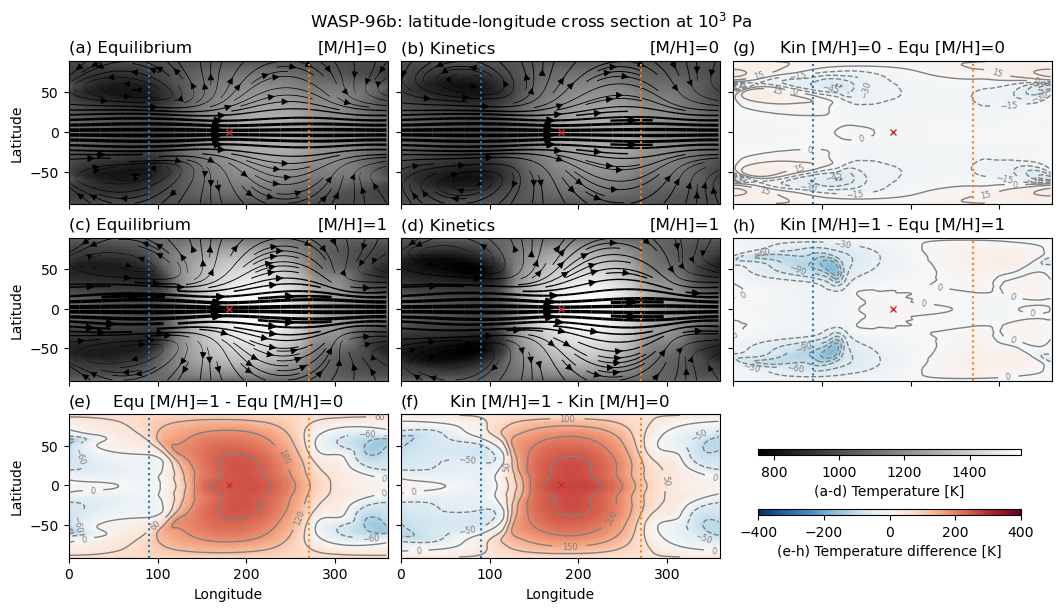

In [14]:
# Plot with variable difference
for tgt_plev_k in tqdm([f"{i:1.0e}" for i in tgt_plevs]):
    fig, axs = plt.subplots(
        3, 3, figsize=(10.5, 6), sharex=True, sharey=True, constrained_layout=True
    )
    # Variable and horizontal wind
    iletters = subplot_label_generator()
    for mdh, axrow in zip(["mdh_0", "mdh_1"], axs[0:2, 0:2]):
        for exp, ax in zip(["equilibrium", "kinetics"], axrow):
            # Variable
            plt_var = vrbls[planet][exp][mdh][tgt_plev_k][f"{var}_plev_mean"].data
            p0 = ax.pcolormesh(X, Y, plt_var, norm=var_norm, cmap=cmap)
            # Horizontal wind
            U = vrbls[planet][exp][mdh][tgt_plev_k]["u_plev_mean"].data
            V = vrbls[planet][exp][mdh][tgt_plev_k]["v_plev_mean"].data
            WSPD = np.sqrt(U**2 + V**2)
            lw = 3 * WSPD / wspd_cmmn_max
            ax.streamplot(X, Y, U, V, density=[1, 1], linewidth=lw, color="k")
            # Common
            ax.set_title(f"({next(iletters)}) {exp.capitalize()}", loc="left")
            ax.set_title(f"[M/H]={mdh[-1]}", loc="right")
    # Variable colorbar
    cax_var = fig.add_axes([2.15 * 1 / 3, 0.25, 1 / 4, 0.01])
    cax_var_bar = fig.colorbar(
        p0, ax=axrow, cax=cax_var, label=cbar_lbl_main, orientation="horizontal", shrink=0.5
    )
    # Variable difference
    plt_var_equ_mdh_0 = vrbls[planet]["equilibrium"]["mdh_0"][tgt_plev_k][f"{var}_plev_mean"]
    plt_var_kin_mdh_0 = vrbls[planet]["kinetics"]["mdh_0"][tgt_plev_k][f"{var}_plev_mean"]
    plt_var_equ_mdh_1 = vrbls[planet]["equilibrium"]["mdh_1"][tgt_plev_k][f"{var}_plev_mean"]
    plt_var_kin_mdh_1 = vrbls[planet]["kinetics"]["mdh_1"][tgt_plev_k][f"{var}_plev_mean"]
    plt_var_equ_mdh_1_m_equ_mdh_0 = (plt_var_equ_mdh_1 - plt_var_equ_mdh_0).data
    plt_var_kin_mdh_1_m_kin_mdh_0 = (plt_var_kin_mdh_1 - plt_var_kin_mdh_0).data
    plt_var_kin_mdh_0_m_equ_mdh_0 = (plt_var_kin_mdh_0 - plt_var_equ_mdh_0).data
    plt_var_kin_mdh_1_m_equ_mdh_1 = (plt_var_kin_mdh_1 - plt_var_equ_mdh_1).data
    # Variable difference plot
    p20 = axs[2, 0].pcolormesh(X, Y, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_pc_kws)
    p20c = axs[2, 0].contour(X, Y, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_cr_kws)
    axs[2, 0].clabel(p20c, p20c.levels, inline=True, fontsize=6.0, fmt=cr_fmt)

    axs[2, 0].set_title("(e)", loc="left")
    axs[2, 0].set_title(f"Equ [M/H]=1 - Equ [M/H]=0", loc="center")
    p21 = axs[2, 1].pcolormesh(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_pc_kws)
    p21c = axs[2, 1].contour(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cr_kws)
    axs[2, 1].clabel(p21c, p21c.levels, inline=True, fontsize=6, fmt=cr_fmt)

    axs[2, 1].set_title("(f)", loc="left")
    axs[2, 1].set_title(f"Kin [M/H]=1 - Kin [M/H]=0", loc="center")
    p02 = axs[0, 2].pcolormesh(X, Y, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_pc_kws)
    p02c = axs[0, 2].contour(X, Y, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_cr_kws)
    axs[0, 2].clabel(p02c, p02c.levels, inline=True, fontsize=6, fmt=cr_fmt)

    axs[0, 2].set_title("(g)", loc="left")
    axs[0, 2].set_title(f"Kin [M/H]=0 - Equ [M/H]=0", loc="center")
    p12 = axs[1, 2].pcolormesh(X, Y, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_pc_kws)
    p12c = axs[1, 2].contour(X, Y, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_cr_kws)
    axs[1, 2].clabel(p12c, p12c.levels, inline=True, fontsize=6, fmt=cr_fmt)

    axs[1, 2].set_title("(h)", loc="left")
    axs[1, 2].set_title(f"Kin [M/H]=1 - Equ [M/H]=1", loc="center")
    axs[2, 2].axis("off")
    # Variable difference colorbar
    cax_diff = fig.add_axes([2.15 * 1 / 3, 0.15, 1 / 4, 0.01])
    cax_diff_bar = fig.colorbar(
        p20,
        ax=axs[2, 0],
        cax=cax_diff,
        label=cbar_lbl_diff,
        orientation="horizontal",
        shrink=0.5,
    )
    if var in ["ch4", "hcn", "nh3"]:
        cax_diff_bar.set_ticks(
            np.concatenate([-np.logspace(-12, -2, 11)[::-1], [0], np.logspace(-12, -2, 11)])[1::4]
        )
        cax_diff_bar.set_ticklabels(
            [
                latex_float(i)
                for i in np.concatenate(
                    [-np.logspace(-12, -2, 11)[::-1], [0], np.logspace(-12, -2, 11)]
                )[1::4]
            ]
        )
    # Common
    for iax in axs.flatten()[0:-1]:
        iax.set_xlim(left=0)
        iax.plot(180, 0, markersize=4, marker="x", color="C3")
        iax.axvline(x=90, color="C0", linestyle="dotted")
        iax.axvline(x=270, color="C1", linestyle="dotted")
        if iax.get_subplotspec().is_first_col():
            iax.set_ylabel("Latitude")
    for iax in [axs[2, 0], axs[2, 1]]:
        iax.set_xlabel("Longitude")
    fig.suptitle(f"{PLANETS[planet]['tex']}: latitude-longitude cross section at $10^{3}$ Pa")
    figname_png = f"{planet}_hwind_{var}_at_pres{tgt_plev_k}Pa_scale_cmmn_w_diffs.png"
    figname_pdf = f"{planet}_hwind_{var}_at_pres{tgt_plev_k}Pa_scale_cmmn_w_diffs.pdf"
    fig.savefig(path_to_project / folder / "cross_section_latlon_at_plevs" / figname_png)
    fig.savefig(
        path_to_project / folder / "cross_section_latlon_at_plevs" / figname_pdf, format="pdf"
    )

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_34400/511016808.py:44: UserWarning: No contour levels were found within the data range.
  p21c = axs[2, 1].contour(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cr_kws)


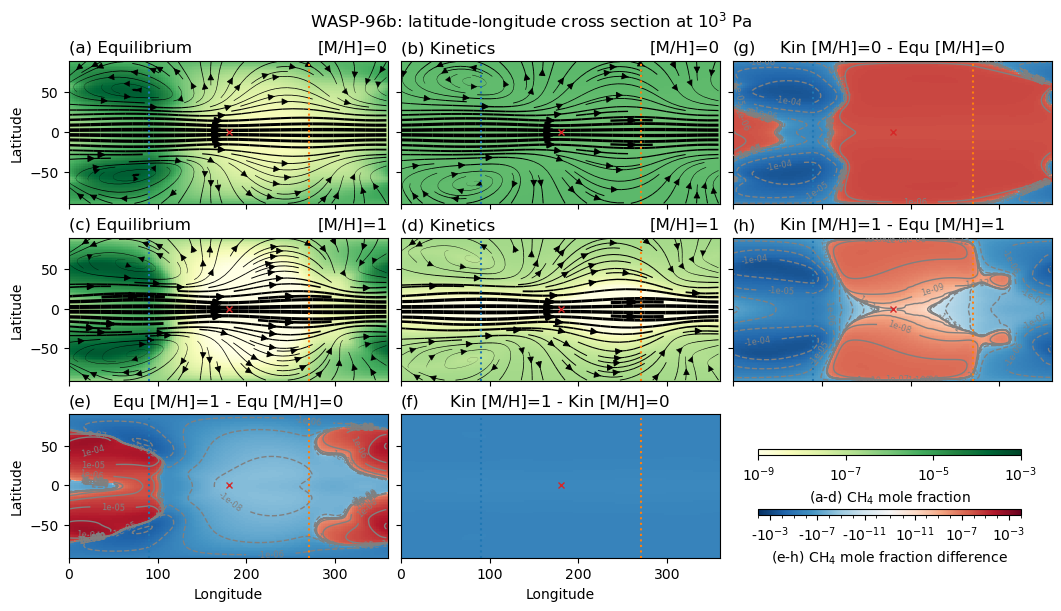

In [18]:
# Plot with variable difference
for tgt_plev_k in tqdm([f"{i:1.0e}" for i in tgt_plevs]):
    fig, axs = plt.subplots(
        3, 3, figsize=(10.5, 6), sharex=True, sharey=True, constrained_layout=True
    )
    # Variable and horizontal wind
    iletters = subplot_label_generator()
    for mdh, axrow in zip(["mdh_0", "mdh_1"], axs[0:2, 0:2]):
        for exp, ax in zip(["equilibrium", "kinetics"], axrow):
            # Variable
            plt_var = vrbls[planet][exp][mdh][tgt_plev_k][f"{var}_plev_mean"].data
            p0 = ax.pcolormesh(X, Y, plt_var, norm=var_norm, cmap=cmap)
            # Horizontal wind
            U = vrbls[planet][exp][mdh][tgt_plev_k]["u_plev_mean"].data
            V = vrbls[planet][exp][mdh][tgt_plev_k]["v_plev_mean"].data
            WSPD = np.sqrt(U**2 + V**2)
            lw = 3 * WSPD / wspd_cmmn_max
            ax.streamplot(X, Y, U, V, density=[1, 1], linewidth=lw, color="k")
            # Common
            ax.set_title(f"({next(iletters)}) {exp.capitalize()}", loc="left")
            ax.set_title(f"[M/H]={mdh[-1]}", loc="right")
    # Variable colorbar
    cax_var = fig.add_axes([2.15 * 1 / 3, 0.25, 1 / 4, 0.01])
    cax_var_bar = fig.colorbar(
        p0, ax=axrow, cax=cax_var, label=cbar_lbl_main, orientation="horizontal", shrink=0.5
    )
    # Variable difference
    plt_var_equ_mdh_0 = vrbls[planet]["equilibrium"]["mdh_0"][tgt_plev_k][f"{var}_plev_mean"]
    plt_var_kin_mdh_0 = vrbls[planet]["kinetics"]["mdh_0"][tgt_plev_k][f"{var}_plev_mean"]
    plt_var_equ_mdh_1 = vrbls[planet]["equilibrium"]["mdh_1"][tgt_plev_k][f"{var}_plev_mean"]
    plt_var_kin_mdh_1 = vrbls[planet]["kinetics"]["mdh_1"][tgt_plev_k][f"{var}_plev_mean"]
    plt_var_equ_mdh_1_m_equ_mdh_0 = (plt_var_equ_mdh_1 - plt_var_equ_mdh_0).data
    plt_var_kin_mdh_1_m_kin_mdh_0 = (plt_var_kin_mdh_1 - plt_var_kin_mdh_0).data
    plt_var_kin_mdh_0_m_equ_mdh_0 = (plt_var_kin_mdh_0 - plt_var_equ_mdh_0).data
    plt_var_kin_mdh_1_m_equ_mdh_1 = (plt_var_kin_mdh_1 - plt_var_equ_mdh_1).data
    # Variable difference plot
    p20 = axs[2, 0].pcolormesh(X, Y, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_pc_kws)
    p20c = axs[2, 0].contour(X, Y, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_cr_kws)
    axs[2, 0].clabel(p20c, p20c.levels, inline=True, fontsize=6.0, fmt=cr_fmt)

    axs[2, 0].set_title("(e)", loc="left")
    axs[2, 0].set_title(f"Equ [M/H]=1 - Equ [M/H]=0", loc="center")
    p21 = axs[2, 1].pcolormesh(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_pc_kws)
    p21c = axs[2, 1].contour(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cr_kws)
    axs[2, 1].clabel(p21c, p21c.levels, inline=True, fontsize=6, fmt=cr_fmt)

    axs[2, 1].set_title("(f)", loc="left")
    axs[2, 1].set_title(f"Kin [M/H]=1 - Kin [M/H]=0", loc="center")
    p02 = axs[0, 2].pcolormesh(X, Y, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_pc_kws)
    p02c = axs[0, 2].contour(X, Y, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_cr_kws)
    axs[0, 2].clabel(p02c, p02c.levels, inline=True, fontsize=6, fmt=cr_fmt)

    axs[0, 2].set_title("(g)", loc="left")
    axs[0, 2].set_title(f"Kin [M/H]=0 - Equ [M/H]=0", loc="center")
    p12 = axs[1, 2].pcolormesh(X, Y, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_pc_kws)
    p12c = axs[1, 2].contour(X, Y, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_cr_kws)
    axs[1, 2].clabel(p12c, p12c.levels, inline=True, fontsize=6, fmt=cr_fmt)

    axs[1, 2].set_title("(h)", loc="left")
    axs[1, 2].set_title(f"Kin [M/H]=1 - Equ [M/H]=1", loc="center")
    axs[2, 2].axis("off")
    # Variable difference colorbar
    cax_diff = fig.add_axes([2.15 * 1 / 3, 0.15, 1 / 4, 0.01])
    cax_diff_bar = fig.colorbar(
        p20,
        ax=axs[2, 0],
        cax=cax_diff,
        label=cbar_lbl_diff,
        orientation="horizontal",
        shrink=0.5,
    )
    if var in ["ch4", "hcn", "nh3"]:
        cax_diff_bar.set_ticks(
            np.concatenate([-np.logspace(-12, -2, 11)[::-1], [0], np.logspace(-12, -2, 11)])[1::4]
        )
        cax_diff_bar.set_ticklabels(
            [
                latex_float(i)
                for i in np.concatenate(
                    [-np.logspace(-12, -2, 11)[::-1], [0], np.logspace(-12, -2, 11)]
                )[1::4]
            ]
        )
    # Common
    for iax in axs.flatten()[0:-1]:
        iax.set_xlim(left=0)
        iax.plot(180, 0, markersize=4, marker="x", color="C3")
        iax.axvline(x=90, color="C0", linestyle="dotted")
        iax.axvline(x=270, color="C1", linestyle="dotted")
        if iax.get_subplotspec().is_first_col():
            iax.set_ylabel("Latitude")
    for iax in [axs[2, 0], axs[2, 1]]:
        iax.set_xlabel("Longitude")
    fig.suptitle(f"{PLANETS[planet]['tex']}: latitude-longitude cross section at $10^{3}$ Pa")
    figname_png = f"{planet}_hwind_{var}_at_pres{tgt_plev_k}Pa_scale_cmmn_w_diffs.png"
    figname_pdf = f"{planet}_hwind_{var}_at_pres{tgt_plev_k}Pa_scale_cmmn_w_diffs.pdf"
    fig.savefig(path_to_project / folder / "cross_section_latlon_at_plevs" / figname_png)
    fig.savefig(
        path_to_project / folder / "cross_section_latlon_at_plevs" / figname_pdf, format="pdf"
    )